In [53]:
import torch

import matplotlib.pyplot as plt
import numpy as np

import time

In [54]:
def f(x):
    return x**2

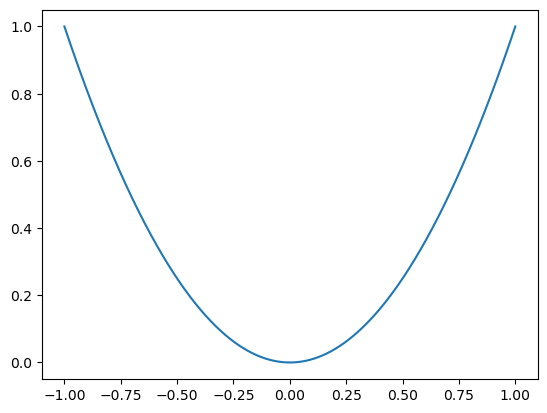

In [55]:
# Create a tensor with 1000 points between -10 and 10
x = torch.linspace(-1, 1, 1000)

# Apply the function to each point
y = f(x)

# Plot the result
plt.plot(x, y)
plt.show()

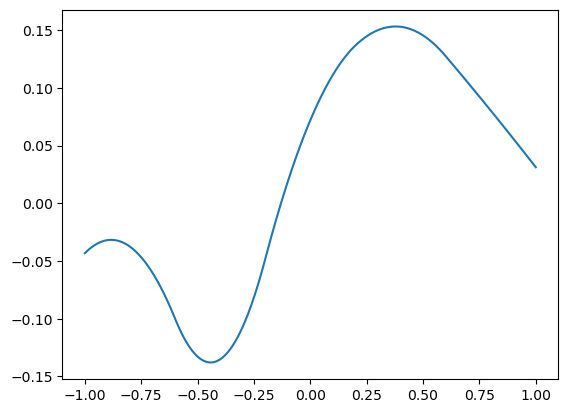

In [56]:
num_intervals = 5
spline_order = 2
region = [-1, 1]

grid_points = torch.linspace(region[0], region[1], num_intervals + 1)
ext_grid_points = torch.cat((torch.arange(region[0] - spline_order, region[0]), grid_points, torch.arange(region[1] + 1, region[1] + spline_order + 1)))

def cox_de_boor(ext_grid_points, i, degree, time):
    if degree == 0:
        return 1.0 if ext_grid_points[i] <= time < ext_grid_points[i + 1] else 0.0
    
    left_side = (time - ext_grid_points[i]) / (ext_grid_points[i + degree] - ext_grid_points[i]) * cox_de_boor(ext_grid_points, i, degree - 1, time)
    right_side = (ext_grid_points[i + degree + 1] - time) / (ext_grid_points[i + degree + 1] - ext_grid_points[i + 1]) * cox_de_boor(ext_grid_points, i + 1, degree - 1, time)
    return left_side + right_side

num_control_points = num_intervals + spline_order
variance = 0.1
control_points = torch.as_tensor(np.random.normal(0, variance, num_control_points))

def evaluate_spline(control_points, ext_grid_points, degree, time):
    result = 0.0
    for i in range(num_intervals + degree):
        result += control_points[i] * cox_de_boor(ext_grid_points, i, degree, time)
    return result

xs = torch.linspace(region[0], region[1], 1000)
ys = torch.zeros(xs.size())

for i in range(xs.size(0)):
    ys[i] = evaluate_spline(control_points, ext_grid_points, spline_order, xs[i])

plt.plot(xs, ys)
plt.show()

In [57]:
start = time.time()

# Optimize control points to match f(x)
control_points.requires_grad = True
opt = torch.optim.Adam([control_points], lr=1)
# opt = torch.optim.LBFGS([control_points], lr=100)

for i in range(0):
    opt.zero_grad()
    loss = 0.0
    for j in range(xs.size(0)):
        loss += (evaluate_spline(control_points, ext_grid_points, spline_order, xs[j]) - f(xs[j]))**2
    loss.backward()
    opt.step()

    if i % 1 == 0:
        print(f"Epoch {i}, loss: {loss.item()}")

print(f"Optimization took {time.time() - start} seconds")

Optimization took 0.0007114410400390625 seconds


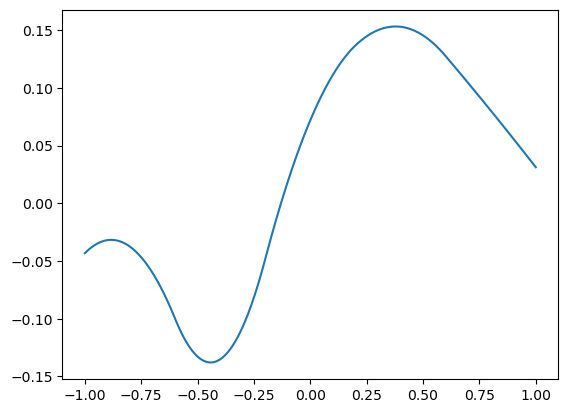

In [58]:
# Plot the result
for i in range(xs.size(0)):
    ys[i] = evaluate_spline(control_points, ext_grid_points, spline_order, xs[i])

plt.plot(xs, ys.detach().numpy())
plt.show()

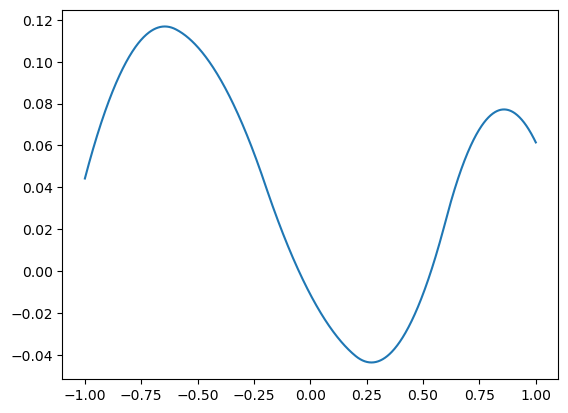

In [61]:
# Vectorized version
control_points = torch.as_tensor(np.random.normal(0, variance, num_control_points))

def vect_cox_de_boor(ext_grid_points, i, degree, times):
    if degree == 0:
        return (ext_grid_points[i] <= times) * (times < ext_grid_points[i + 1])
    
    left_side = (times - ext_grid_points[i]) / (ext_grid_points[i + degree] - ext_grid_points[i]) * vect_cox_de_boor(ext_grid_points, i, degree - 1, times)
    right_side = (ext_grid_points[i + degree + 1] - times) / (ext_grid_points[i + degree + 1] - ext_grid_points[i + 1]) * vect_cox_de_boor(ext_grid_points, i + 1, degree - 1, times)

    return left_side + right_side

def vect_evaluate_spline(control_points, ext_grid_points, degree, times):
    result = 0.0
    for i in range(num_intervals + degree):
        result += control_points[i] * vect_cox_de_boor(ext_grid_points, i, degree, times)
        
    return result

ys = vect_evaluate_spline(control_points, ext_grid_points, spline_order, xs)

plt.plot(xs, ys)
plt.show()

Epoch 0, loss: 0.15884988009929657
Epoch 100, loss: 0.005516699515283108
Epoch 200, loss: 0.002883496228605509
Epoch 300, loss: 0.001879440969787538
Epoch 400, loss: 0.0011190332006663084
Epoch 500, loss: 0.000612039293628186
Epoch 600, loss: 0.000308163434965536
Epoch 700, loss: 0.0001428930991096422
Epoch 800, loss: 6.097710138419643e-05
Epoch 900, loss: 2.3912827600724995e-05
Optimization took 2.7342636585235596 seconds


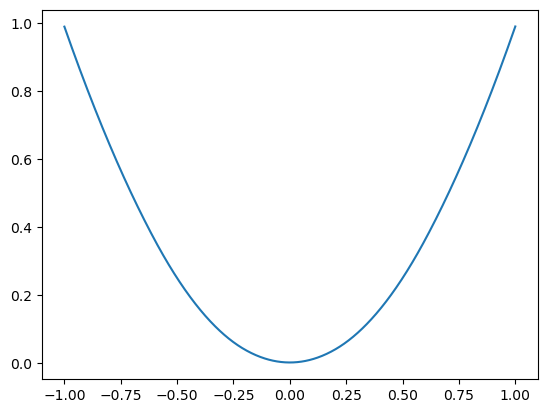

In [62]:
start = time.time()

# Optimize control points to match f(x)
control_points.requires_grad = True
opt = torch.optim.Adam([control_points], lr=0.01)
# opt = torch.optim.LBFGS([control_points], lr=100)

for i in range(1000):
    opt.zero_grad()
    loss = (vect_evaluate_spline(control_points, ext_grid_points, spline_order, xs) - f(xs))**2
    loss = loss.mean()
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print(f"Epoch {i}, loss: {loss.item()}")

print(f"Optimization took {time.time() - start} seconds")

ys = vect_evaluate_spline(control_points, ext_grid_points, spline_order, xs)

plt.plot(xs, ys.detach().numpy())
plt.show()